In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import signal
import random
import scipy.integrate as sc

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['agg.path.chunksize'] = 10000

# Problem 1: LIGO Gravitational Waves

In [2]:
directory = './LOSC_Event_tutorial-master/'

In [4]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tH=template[0]
    tL=template[1]
    return tH,tL

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'][()]
    utc=meta['UTCstart'][()]
    duration=meta['Duration'][()]
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [5]:
fnameH = directory + 'H-H1_LOSC_4_V2-1126259446-32.hdf5'
fnameL = directory + 'L-L1_LOSC_4_V2-1126259446-32.hdf5'
print('reading files \n',fnameH, '\n', fnameL, '\n')
strainH,dtH,utcH=read_file(fnameH)
strainL,dtL,utcL=read_file(fnameL)

template_name = directory + 'GW150914_4_template.hdf5'
print('reading template \n',template_name)
tH,tL=read_template(template_name)

reading files 
 ./LOSC_Event_tutorial-master/H-H1_LOSC_4_V2-1126259446-32.hdf5 
 ./LOSC_Event_tutorial-master/L-L1_LOSC_4_V2-1126259446-32.hdf5 

reading template 
 ./LOSC_Event_tutorial-master/GW150914_4_template.hdf5


In [6]:
timeL = np.linspace(0, len(strainL), len(strainL))*dtL
timeH = np.linspace(0, len(strainH), len(strainH))*dtH

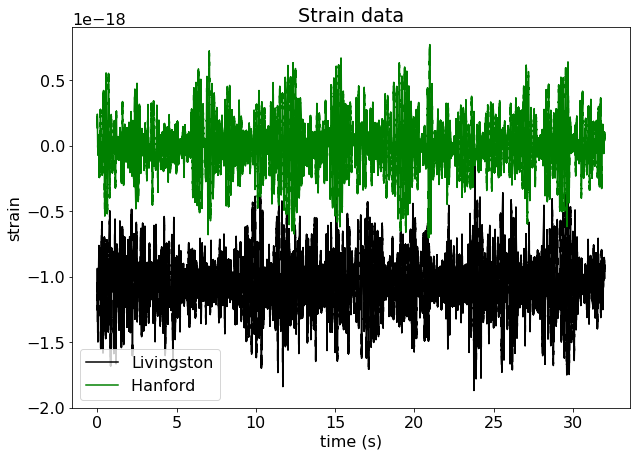

In [7]:
plt.plot(timeL, strainL, color='black', label='Livingston')
plt.plot(timeH, strainH, color='green', label='Hanford ')
plt.ylabel('strain')
plt.xlabel('time (s)')
plt.legend()
plt.title('Strain data')
plt.show()

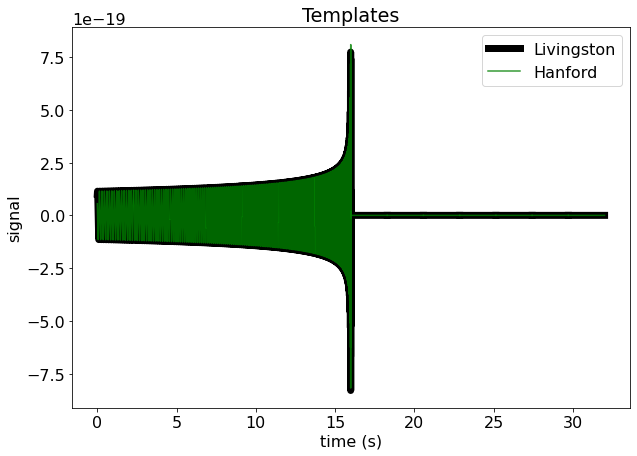

In [8]:
plt.plot(timeL, tL, linewidth=7, color='black', label='Livingston')
plt.plot(timeH, tH, color='green', label='Hanford', alpha=0.8, ms=2)
plt.ylabel('signal')
plt.xlabel('time (s)')
plt.legend()
plt.title('Templates')
plt.show()

# part a) Noise Models

To determine a noise model for the Livingston and Hanford detectors, I used the smoothed power spectrum of the strain data for each of them. The first step was to window the data to avoid a large discontinuity from spraying power at all scales of the power spectrum. In order to do this, I used a tuckey window, which looked like it had a relatively flat section in the middle and dropped to 0 at the edges, meaning it would fix the power spraying issue but keep most of the signal in sections other than the edges. To apply the window, I multiplied the strain data by the window before taking the fourier transform. 

Then, by taking the square of the fourier transform, I had the power spectrum of the data. Looking at the first plot below, it is clear that even though we have some real spikes, a lot of the values especially at higher frequencies take up a large range. To fix this, I smoothed the power spectrum by convolving with a gaussian. I found that using $\sigma = 2$, there is nice smoothing without loosing the amplitudes of the spikes which we want to keep in the noise model. This seemed to work well with all events and for both detectors. Since this method did not seem to impact the lines very much, I assumed it was enough and didn't require more attention specifically for the lines. The second plot shows the smoothed out power spectrum for the first event as an example. 

In [9]:
def smooth_vector(vec, sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

In [10]:
# creating a window function
x = np.linspace(-np.pi/2,np.pi/2,len(strainL))
win = signal.tukey(len(x))

In [11]:
# getting the frequency range
dfreq = 1/timeL[-1]
freq = np.arange(len(strainL))*dfreq

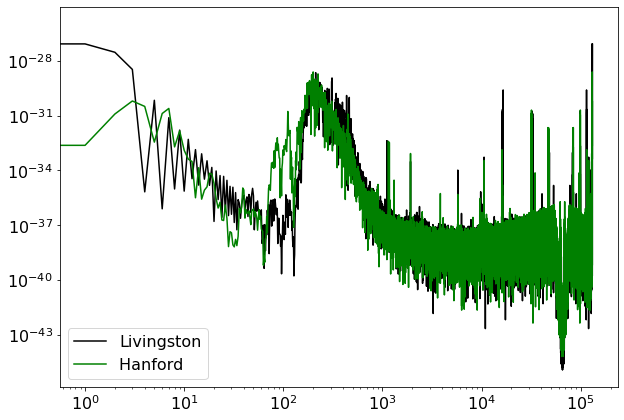

In [12]:
# getting the power spectrum
ps_L = np.abs(np.fft.fft(strainL * win))**2
ps_H = np.abs(np.fft.fft(strainH * win))**2
plt.loglog(ps_L, color='black', label='Livingston')
plt.loglog(ps_H, color='green', label='Hanford ')
plt.legend()
plt.show()

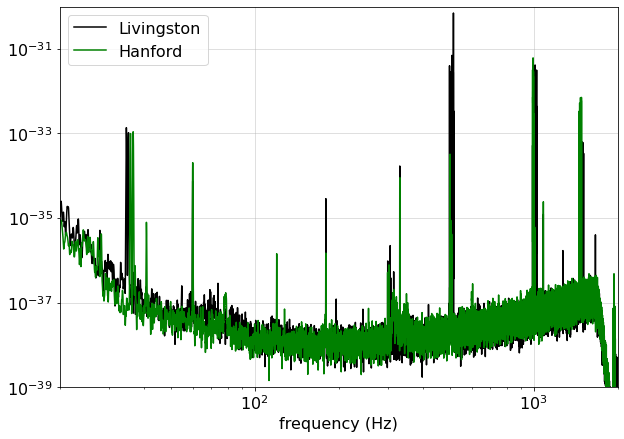

In [13]:
# smoothing
psL_smooth=smooth_vector(ps_L, 2)
psH_smooth=smooth_vector(ps_H, 2)

plt.loglog(freq, psL_smooth, color='black', label='Livingston')
plt.loglog(freq, psH_smooth, color='green', label='Hanford')
plt.xlim(20, 2000)
plt.ylim(1e-39, 1e-30)
plt.legend()
plt.xlabel('frequency (Hz)')
plt.grid(alpha=0.5)
plt.show()

# part b) search for events with matched filters

Using the noise models, I used matched filters to search for the 4 events using the 4 templates provided. The first step was to pre-whiten the template and the data using the $N^{-1}$ matrix obtained by taking the reciprocal of the smoothed power spectrum. We also masked frequencies which noise blowing up or that contained a lot of digital filtering noise. After pre-whitening the data, we can see in the first plot below that the complex wavelike errors have been converted into simple white noise. Similarly, in the second plot, we see that the pre-whitened template now shows that the more significant signal will come from the frequencies just before the merger. 

Applying this pre-whitening has changed the fit into the following operations:

$$A^TAm = A^Td$$

Where the left hand side is simply a normalizing scalar and the right hand side involves the correlation of our pre-whitened data and templates in fourier space. After performing this, the output of the matched filter is shown in the third plot below. There is a very clear peak in the amplitude that looks statistically significant, which means we have been able to detect the GW event. 

After going through this example, I performed the same analysis for all 4 events and both detectors. The results are shown below.

In [15]:
NinvH=1/psH_smooth
NinvL=1/psL_smooth

NinvH[freq>1500]=0 # digital filtering noise
NinvH[freq<20]=0  # blows up lower than this
NinvL[freq>1500]=0
NinvL[freq<20]=0

In [31]:
# fourier transform and whitened template
template_ft = np.fft.fft(tH*win)
template_ft_white = template_ft * np.sqrt(NinvH)
template_white = template_white = np.fft.ifft(template_ft_white)

# fourier transform and whitened data
data_ft = np.fft.fft(strainH*win)
data_ft_white = data_ft * np.sqrt(NinvH)
data_white = np.fft.ifft(data_ft_white)

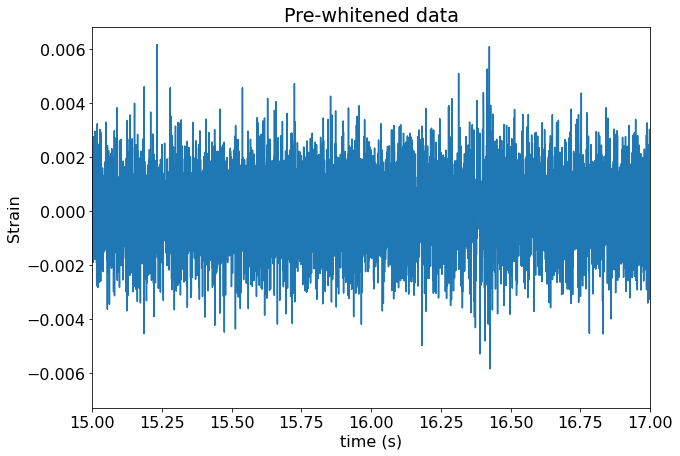

In [45]:
plt.plot(timeH, np.real(data_white))
plt.title('Pre-whitened data')
plt.ylabel('Strain')
plt.xlim(15, 17)
plt.xlabel('time (s)')
plt.show()

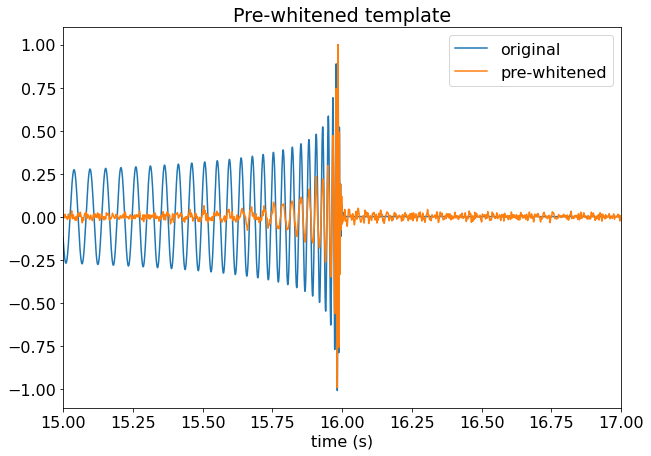

In [46]:
plt.plot(timeH, np.real(tH/tH.max()), label='original')
plt.plot(timeH, np.real(template_white/template_white.max()), label='pre-whitened')
plt.title('Pre-whitened template')
plt.xlim(15, 17)
plt.xlabel('time (s)')
plt.legend()
plt.show()

In [48]:
rhs = np.real(np.fft.ifft(data_ft_white * np.conj(template_ft_white)))
lhs = np.real(template_ft_white.T @ template_ft_white)
mf = rhs / lhs

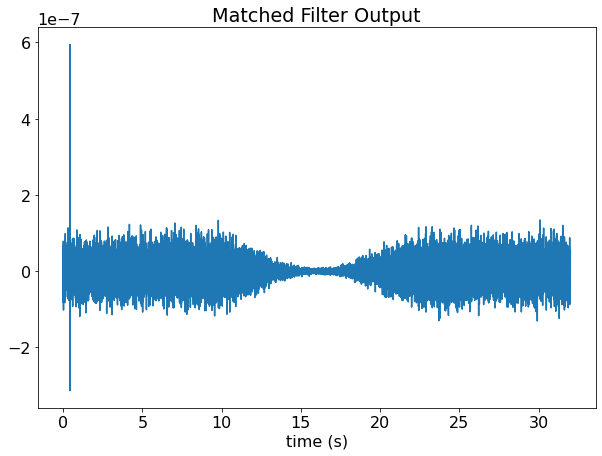

In [51]:
plt.plot(timeH, mf)
plt.title('Matched Filter Output')
plt.xlabel('time (s)')
plt.show()

## Repeating for all 4 events

In [52]:
def match_filter_fun(fnameH, fnameL, tname, sig):
    
    # loading the files
    print('reading files\n',fnameH, '\n', fnameL)
    strainH,dtH,utcH=read_file(fnameH)
    strainL,dtL,utcL=read_file(fnameL)
    print('reading template \n',tname)
    tH,tL=read_template(tname)
    
    # creating window function
    x = np.linspace(-np.pi/2,np.pi/2,len(strainL))
    win = signal.tukey(len(x))
    
    # estimating power spectrum
    ps_L = np.abs(np.fft.fft(strainL * win))**2 / np.size(win)
    ps_H = np.abs(np.fft.fft(strainH * win))**2 / np.size(win)
    
    # smoothing power spectrum
    psL_smooth=smooth_vector(ps_L, sig) 
    psH_smooth=smooth_vector(ps_H, sig) 
    
    # getting noise mode
    NinvL=1/psL_smooth
    NinvH=1/psH_smooth
    NinvH[freq>1500]=0
    NinvH[freq<20]=0  
    NinvL[freq>1500]=0
    NinvL[freq<20]=0
    
    # pre-whitening our template and data
    template_ftH=np.fft.fft(tH*win)
    template_ft_whiteH = template_ftH * np.sqrt(NinvH)
    template_ftL=np.fft.fft(tL*win)
    template_ft_whiteL = template_ftL * np.sqrt(NinvL)

    data_ftH=np.fft.fft(strainH*win)
    data_ft_whiteH = data_ftH * np.sqrt(NinvH)
    data_ftL=np.fft.fft(strainL*win)
    data_ft_whiteL = data_ftL * np.sqrt(NinvL)
    
    # making the match filters
    rhsH = np.real(np.fft.ifft(data_ft_whiteH * np.conj(template_ft_whiteH)))
    lhsH = np.real(template_ft_whiteH.T @ template_ft_whiteH)
    mfH = rhsH / lhsH
    
    rhsL = np.real(np.fft.ifft(data_ft_whiteL * np.conj(template_ft_whiteL)))
    lhsL = np.real(template_ft_whiteL.T @ template_ft_whiteL)
    mfL = rhsL / lhsL
    
    return mfH, lhsH, NinvH, mfL, lhsL, NinvL

reading files
 ./LOSC_Event_tutorial-master/H-H1_LOSC_4_V2-1126259446-32.hdf5 
 ./LOSC_Event_tutorial-master/L-L1_LOSC_4_V2-1126259446-32.hdf5
reading template 
 ./LOSC_Event_tutorial-master/GW150914_4_template.hdf5


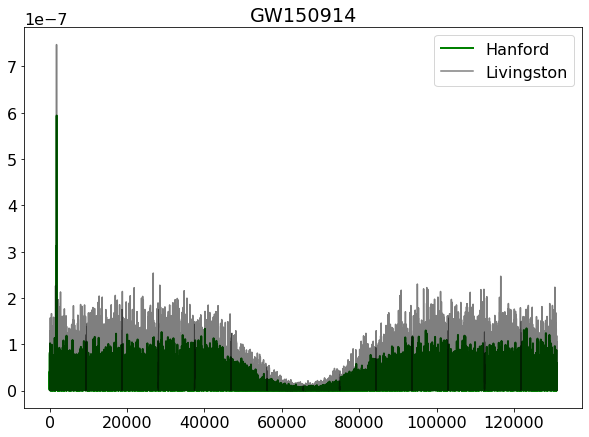

reading files
 ./LOSC_Event_tutorial-master/H-H1_LOSC_4_V2-1128678884-32.hdf5 
 ./LOSC_Event_tutorial-master/L-L1_LOSC_4_V2-1128678884-32.hdf5
reading template 
 ./LOSC_Event_tutorial-master/LVT151012_4_template.hdf5


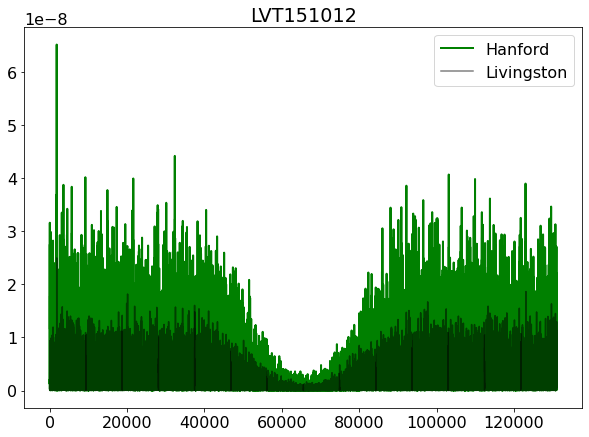

reading files
 ./LOSC_Event_tutorial-master/H-H1_LOSC_4_V2-1135136334-32.hdf5 
 ./LOSC_Event_tutorial-master/L-L1_LOSC_4_V2-1135136334-32.hdf5
reading template 
 ./LOSC_Event_tutorial-master/GW151226_4_template.hdf5


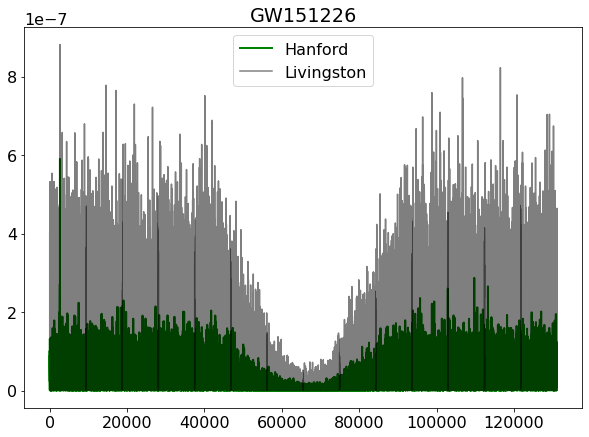

reading files
 ./LOSC_Event_tutorial-master/H-H1_LOSC_4_V1-1167559920-32.hdf5 
 ./LOSC_Event_tutorial-master/L-L1_LOSC_4_V1-1167559920-32.hdf5
reading template 
 ./LOSC_Event_tutorial-master/GW170104_4_template.hdf5


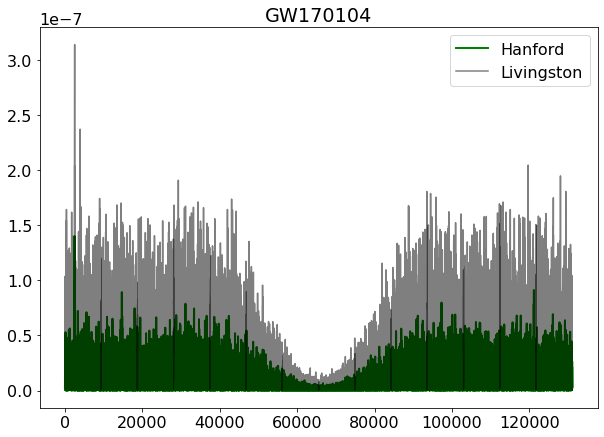

In [53]:
mfs = []
lhss = []
Ninvs = []


filenames = [directory + 'H-H1_LOSC_4_V2-1126259446-32.hdf5', directory + 'L-L1_LOSC_4_V2-1126259446-32.hdf5']
template_name = directory + 'GW150914_4_template.hdf5'
mfH, lhsH, NinvH, mfL, lhsL, NinvL = match_filter_fun(filenames[0], filenames[1], template_name, 2)
mfs.append([mfH, mfL])
lhss.append([lhsH, lhsL])
Ninvs.append([NinvH, NinvL])
plt.plot(np.abs(mfH), linewidth=2, color='green', label='Hanford')
plt.plot(np.abs(mfL), alpha=0.5, color='black', label='Livingston')
plt.legend()
plt.title('GW150914')
plt.show()

filenames = [directory + 'H-H1_LOSC_4_V2-1128678884-32.hdf5', directory + 'L-L1_LOSC_4_V2-1128678884-32.hdf5']
template_name = directory + 'LVT151012_4_template.hdf5'
mfH, lhsH, NinvH, mfL, lhsL, NinvL = match_filter_fun(filenames[0], filenames[1], template_name, 2)
mfs.append([mfH, mfL])
lhss.append([lhsH, lhsL])
Ninvs.append([NinvH, NinvL])
plt.plot(np.abs(mfH), linewidth=2, color='green', label='Hanford')
plt.plot(np.abs(mfL), alpha=0.5, color='black', label='Livingston')
plt.legend()
plt.title('LVT151012')
plt.show()

filenames = [directory + 'H-H1_LOSC_4_V2-1135136334-32.hdf5', directory + 'L-L1_LOSC_4_V2-1135136334-32.hdf5']
template_name = directory + 'GW151226_4_template.hdf5'
mfH, lhsH, NinvH, mfL, lhsL, NinvL = match_filter_fun(filenames[0], filenames[1], template_name, 2)
mfs.append([mfH, mfL])
lhss.append([lhsH, lhsL])
Ninvs.append([NinvH, NinvL])
plt.plot(np.abs(mfH), linewidth=2, color='green', label='Hanford')
plt.plot(np.abs(mfL), alpha=0.5, color='black', label='Livingston')
plt.legend()
plt.title('GW151226')
plt.show()

filenames = [directory + 'H-H1_LOSC_4_V1-1167559920-32.hdf5', directory + 'L-L1_LOSC_4_V1-1167559920-32.hdf5']
template_name = directory + 'GW170104_4_template.hdf5'
mfH, lhsH, NinvH, mfL, lhsL, NinvL = match_filter_fun(filenames[0], filenames[1], template_name, 2)
mfs.append([mfH, mfL])
lhss.append([lhsH, lhsL])
Ninvs.append([NinvH, NinvL])
plt.plot(np.abs(mfH), linewidth=2, color='green', label='Hanford')
plt.plot(np.abs(mfL), alpha=0.5, color='black', label='Livingston')
plt.legend()
plt.title('GW170104')
plt.show()

Ninvs = np.array(Ninvs)

# part c) signal-to-noise ratios

I estimated the noise for each event by looking at the scatter of the matched filter output away from both the peak and the dip caused by the windowing. With that, I could estimate the signal-to-noise ratio (SNR) for the 4 events in both detectors separately. 

$$SNR_{1,H} = 16.99, \ \ \ \ \ \ \ \ \  SNR_{1,L} = 11.80$$
$$SNR_{2,H} = 6.47, \ \ \ \ \ \ \ \ \   SNR_{2,L} = 5.50$$
$$SNR_{3,H} = 9.65, \ \ \ \ \ \ \ \ \   SNR_{3,L} = 4.72$$
$$SNR_{4,H} = 7.09, \ \ \ \ \ \ \ \ \   SNR_{4,L} = 6.06$$

Using summation by quadrature, I also found the SNR of the detection when combining both detectors. The results I got were:

$$SNR_{1} = 20.74$$
$$SNR_{2} = 8.49$$
$$SNR_{3} = 10.74$$
$$SNR_{4} = 9.33$$


In [54]:
start, end = 90000, 125000
SNRs = []
for event in mfs:
    eH, eL = event[0], event[1]
    SNR_H = np.max(np.abs(eH)) / np.std(eH[start:end])
    SNR_L = np.max(np.abs(eL)) / np.std(eL[start:end])
    SNRs.append([SNR_H, SNR_L])

In [55]:
SNRs

[[16.99157153986351, 11.895137035420742],
 [6.471844672701312, 5.502198720734452],
 [9.65069179528064, 4.715050452545381],
 [7.0948731460905465, 6.064769308000081]]

In [56]:
combined_SNR = []
for el in SNRs:
    c = np.sqrt(el[0]**2 + el[1]**2)
    combined_SNR.append(c)

In [57]:
combined_SNR

[20.74145097349117, 8.494643266790208, 10.740928865677562, 9.333737285695188]

# part d) analytical SNRs

From the model we can get the analytical expected errors of the matched filter amplitude output by taking:

$$error = \frac{1}{\sqrt{A^TA}}$$

Using this error instead, the values for SNR that I got were:

$$SNR_{1,H} = 10.45, \ \ \ \ \ \ \ \ \   SNR_{1,L} = 9.27$$
$$SNR_{2,H} = 1.76, \ \ \ \ \ \ \ \ \   SNR_{2,L} = 0.95$$
$$SNR_{3,H} = 5.39, \ \ \ \ \ \ \ \ \   SNR_{3,L} = 3.82$$
$$SNR_{4,H} = 3.03, \ \ \ \ \ \ \ \ \   SNR_{4,L} = 4.70$$

$$SNR_{1} = 13.97$$
$$SNR_{2} = 2.00$$
$$SNR_{3} = 6.61$$
$$SNR_{4} = 5.59$$

Comparing these values with what we got using the scatter of the matched filter output, it seems that my noise model is overestimating the errors in the data. I assumed this because it produces a smaller SNR in all cases when compared to the SNR derived from the scatter on the data. Maybe this means that I could have smoothed the power spectrum in a more careful way, or they might also be some normalization errors that cause a mismatch between the estimate of the peak of the matched filter and the analytical error. 

In [58]:
# analytical errors
SNRs_analytical = []
for i, lhs in enumerate(lhss):
    H, L = lhs[0], lhs[1]
    mH, mL = mfs[i][0], mfs[i][1]
    errH = 1/np.sqrt(np.abs(H)) * dfreq
    errL = 1/np.sqrt(np.abs(L)) * dfreq
    SNRH = np.max(np.abs(mH)) / errH
    SNRL = np.max(np.abs(mL)) / errL
    SNRs_analytical.append([SNRH, SNRL])

In [59]:
SNRs_analytical

[[10.452461247149435, 9.267104886041338],
 [1.7641514591750755, 0.9510428995388674],
 [5.386944457756299, 3.822665959473757],
 [3.032076053545012, 4.700204129628244]]

In [60]:
combined_analytical = []
for el in SNRs_analytical:
    c = np.sqrt(el[0]**2 + el[1]**2)
    combined_analytical.append(c)

In [61]:
combined_analytical

[13.969007806285024, 2.004173886585903, 6.605448177729557, 5.593335682279001]

# part e) half-way frequency

To find the frequency where half of the weight comes from above and half comes from below the frequency, I looked at the noise model matrices. This is because the weight comes from the noise at each value of the frequency in fourier space, as the noise model will be uncorrelated in this space. The results I got are printed below, but for clarity are shown here:

- GW150914 $\ \ \ \ \ \ \ \ \ \ \ \  $$\longrightarrow$
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $Hanford = 408.625 Hz   $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \$        Livingston = 431.5 Hz

- LVT151012 $\ \ \ \ \ \ \ \ \ \ \ \  $$\longrightarrow$
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $Hanford = 405.656 Hz $\ \ \ \ \ \ \ \ \ \ \ \ \ \ $        Livingston = 403.03125 Hz

- GW151226 $\ \ \ \ \ \ \ \ \ \ \ \  $$\longrightarrow$
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $Hanford = 377.594 Hz $\ \ \ \ \ \ \ \ \ \ \ \ \ \ $ Livingston = 419.28125 Hz

- GW170104 $\ \ \ \ \ \ \ \ \ \ \ \  $$\longrightarrow$
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $Hanford = 421.5 Hz $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $  Livingston = 387.375 Hz

In [62]:
events = ['GW150914', 'LVT151012', 'GW151226', 'GW170104']

In [63]:
def half_weight(Ninv):
    
    right = np.sum(Ninv)
    left = 0.0
    i, j = 0, 1
    while j < len(Ninv) :
        right -= Ninv[j]
        left += Ninv[i]
         
        # check if left sum has gone past or is equation to the right one
        if left >= right:
            return i        
        j += 1
        i += 1
 
    return None

In [64]:
for i, N in enumerate(Ninvs):
    NH, NL = N[0], N[1]
    halfH, halfL = half_weight(NH), half_weight(NL)
    print(events[i])
    print('Hanford = {} Hz, Livingston = {} Hz'.format(freq[halfH], freq[halfL]))
    print()

GW150914
Hanford = 408.625 Hz, Livingston = 431.5 Hz

LVT151012
Hanford = 405.65625 Hz, Livingston = 403.03125 Hz

GW151226
Hanford = 377.59375 Hz, Livingston = 419.28125 Hz

GW170104
Hanford = 421.5 Hz, Livingston = 387.375 Hz



# part f) localizing the event

We can localize the event to an accuracy given by the time resolution,

$$dt = 0.000244140625 s$$

From the matched filters at Hanford and Livingston, we see that the time shift for our template to align with the signal from the strain data for the first event are:

$$t_H = 0.4404s \ \ \ \ \ \ \ \ \ \ \ \ \ t_L = 0.4316$$

Comparing their arrival times we get that the arrival time difference is given by:

$$t_{diff} = 0.00879 \pm 0.00035 s$$

Where we propagated the error given by the maximum accuracy of determining the times for each detector. 

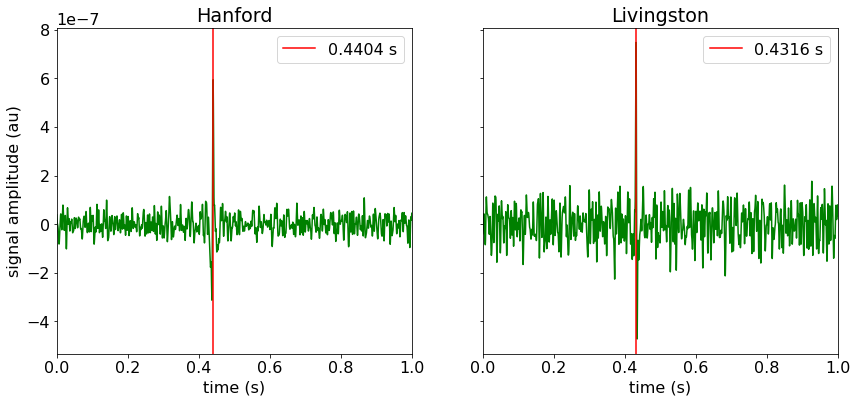

In [73]:
# getting the horizontal shift of the matched filters
indmax = np.argmax(mfs[0][0])
timemaxH = timeH[indmax]
shift_errorH = dtH

indmax = np.argmax(mfs[0][1])
timemaxL = timeL[indmax]
shift_errorL = dtL

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharey=True, squeeze=True)

ax[0].plot(timeH, mfs[0][0], color='green')
ax[0].axvline(timemaxH, color='red', label='{} s'.format(round(timemaxH, 4)))
ax[0].set_xlim(0, 1)
ax[0].legend()
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('signal amplitude (au)')
ax[0].set_title('Hanford')

ax[1].plot(timeL, mfs[0][1], color='green')
ax[1].axvline(timemaxL, color='red', label='{} s'.format(round(timemaxL, 4)))
ax[1].set_xlim(0, 1)
ax[1].legend()
ax[1].set_xlabel('time (s)')
ax[1].set_title('Livingston')
plt.show()

In [74]:
# comparing arrival times on detectors

time_diff = np.abs(timemaxH - timemaxL)
err_time_diff = np.sqrt(shift_errorH**2 + shift_errorL**2)
print('arrival time difference = {} +/- {} s'.format(round(time_diff,5), round(err_time_diff, 5)))

arrival time difference = 0.00879 +/- 0.00035 s


# Problem 2

We assume we have a circular dish illuminated by the gaussian beam pattern of a feed. We are looking for the optimal ratio of the width of the gaussian beam to the radius of the dish $\frac{\sigma}{R}$. We look at the effective area of the dish:

$$A_{eff} = \int^R_0 \int^{2\pi}_0 exp\left(\frac{-r^2}{2\sigma^2}\right)rd\phi dr = 2\pi \int^R_0 exp\left(\frac{-r^2}{2\sigma^2}\right)r dr$$

Integrating this analytically, we get:

$$A_{eff} = -2\pi\sigma^2\left[exp\left(\frac{-R^2}{2\sigma^2}\right) - 1\right]$$

Then similarly, the total beam integral is given by:

$$B_t = 2\pi \int^\infty_0 exp\left(\frac{-r^2}{2\sigma^2}\right)r dr \longrightarrow B_t = 2\pi\sigma^2$$

Then the fraction of the feed beam that ends up on the primary is given by:

$$A_f = \frac{A_{eff}}{B_t}$$

For this exercise, I normalize the effective area by the total area of the dish $A = \pi R^2$.

Running this for sigmas going up to $\sigma = 1.5R$, we see that the optimal ratio is:

$$\left(\frac{\sigma}{R}\right)_{optimal}= 0.631$$

The plot of the signal strength at the feed for varying values of this ratio is shown below. We find that at the peak, the normalized effective area of the dish is:

$$\frac{A_{eff}}{A} = 0.569$$

And we also know that about $1 - 0.631 = 0.285$ of the beam will land outside of the dish, so

$$B_{off} = 0.285$$

If we consider that this fraction of the beam is landing on a $300K$ ground, then its measurement will contribute to the system temperature in the radiometer equation. So setting up the following values:

$$B = 1.4\times 10^9 GHz$$
$$t = 120 s$$
$$T_{spill} = B_{t, off} \times 300K \approx 85.4$$
$$T_{noise} = 20K$$

Where we are using a bandwith like the GBT and an observation of 2 minutes. $T_{spill}$ is the temperature that will be added to the the system temperature due to the spill over of the beam off the dish. And $T_{noise}$ is the noise temperature of a good cryogenic receiver. We then use the radiometer equation to find the best resolution using only the noise temperature vs the noise temperature and the spillover temperature. 

$$\delta T = \frac{T_{sys}}{\sqrt{Bt}}$$

The we get:

$$\delta T =  4.88\times 10^{-5} \ \ \ \ \ \ \ \ \ \ \ \ \delta T  = 2.57 \times 10^{-4} K$$

We see that this infact creates constraints on our ability to measure fluctuations in the temperature/flux that could have a really bad impact on our sensitivity. 

In [76]:
radius = 100
sigs = np.linspace(0.0001, radius*1.5, 100000)
ratio = sigs / radius
A = np.pi * radius **2

In [77]:
Aeff = []
for sig in sigs:
    Aeff.append(-2*np.pi*sig**2*(np.exp(-radius**2/(2*sig**2)) - 1))
Aeff = np.array(Aeff)/A

In [78]:
Bt = []
for sig in sigs:
    Bt.append(2*np.pi*sig**2)
Bt = np.array(Bt)

In [79]:
final = (Aeff) * Aeff*A/Bt

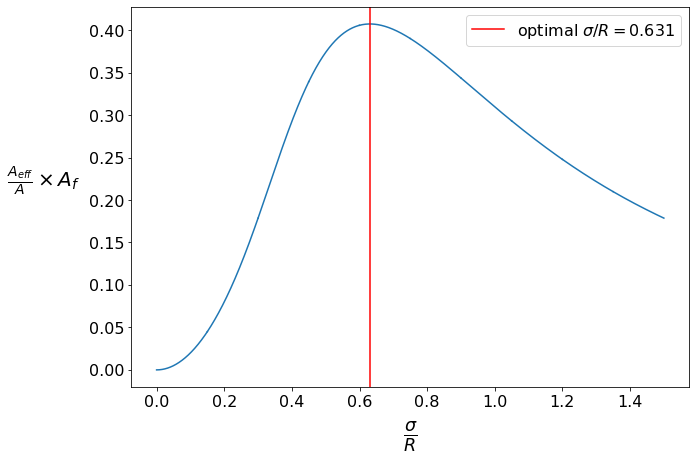

In [80]:
plt.plot(ratio, final)
plt.axvline(ratio[np.argmax(final)], color='red', label='optimal $\sigma/R = $' + str(round(ratio[np.argmax(final)], 3)))
plt.legend()
plt.xlabel(r'$\frac{\sigma}{R}$', labelpad=10, fontsize=25)
plt.ylabel(r'$\frac{A_{eff}}{A} \times A_f$', rotation=0, labelpad=45, fontsize=20)
plt.show()

In [81]:
print('at maximum, Aeff/A =', Aeff[np.argmax(final)])

at maximum, Aeff/A = 0.5693336440039718


In [82]:
# getting fraction of the beam off of primary
frac = Aeff*A/Bt
off = 1 - frac[np.argmax(final)]
print('The fraction of the beam that ends up off of the primary is \n f =', round(off, 3))

The fraction of the beam that ends up off of the primary is 
 f = 0.285


In [92]:
B = 1.4e9 # 1.4 GHz bandwidth like GBT
t = 120   # seconds of observation
T_spill = 300 * off
T_noise= 20
# temperature increase based on the extra spill over
Tsys = T_spill + T_noise
deltaT = Tsys / np.sqrt(B*t)
delta_clean = T_noise / np.sqrt(B*t)

In [93]:
print(delta_clean, deltaT)

4.8795003647426656e-05 0.00025714832677645085
